In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [6]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


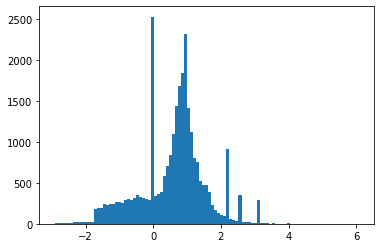

In [8]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [10]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [11]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [12]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

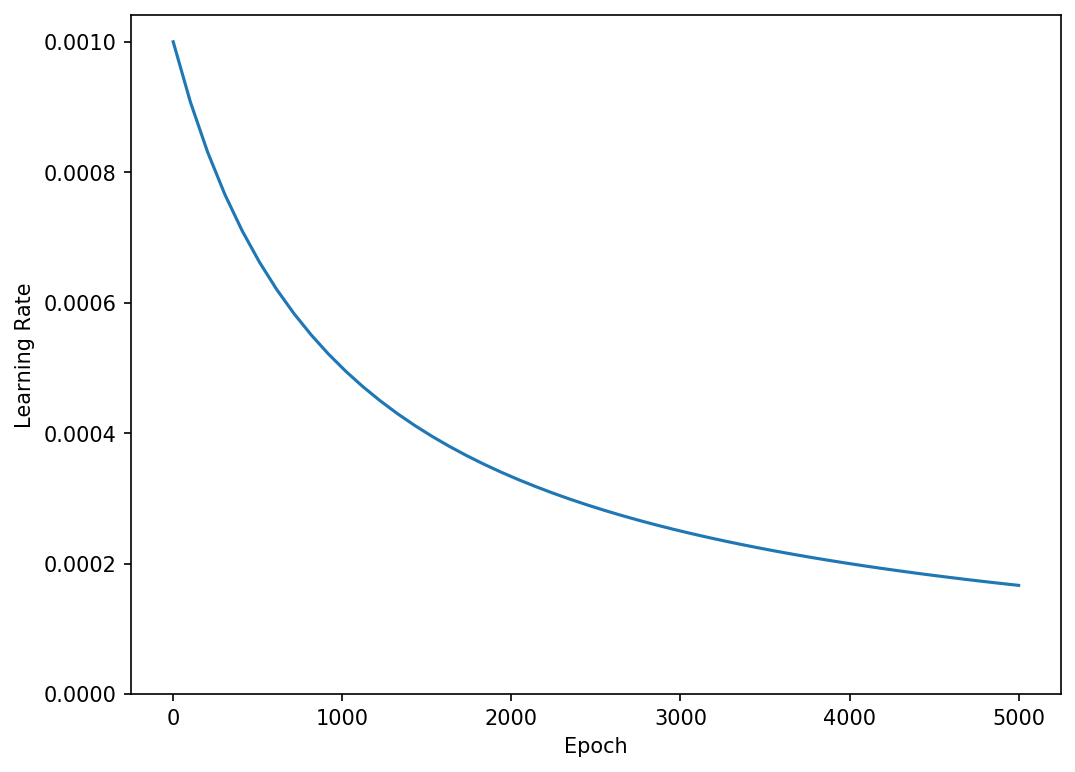

In [13]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6), dpi=150)
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [14]:
# 因为训练时间短并且训练周期长，因此全输出是没必要的，以下代码实现每100个 epoch 打印一次训练进度；
class EpochDots(tf.keras.callbacks.Callback):
    """
    A simple callback that prints a "." every epoch, with occasional reports.

    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """
        
    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='')

In [26]:
def get_callbacks(name):
    return [
        EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [27]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    
    if optimizer is None:
        optimizer = get_optimizer()
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy'])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    
    return history

In [28]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4850,  binary_crossentropy:0.7646,  loss:0.7646,  val_accuracy:0.4840,  val_binary_crossentropy:0.7444,  val_loss:0.7444,  
....................................................................................................
Epoch: 100, accuracy:0.5819,  binary_crossentropy:0.6322,  loss:0.6322,  val_accuracy:0.5850,  val_binary_crossentropy:0.6259,  val_loss:0.6259,  
....................................................................................................
Epoch: 200, accuracy:0.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

prop_cycle = plt.rcParams['axes.prop_cycle']
COLOR_CYCLE = prop_cycle.by_key()['color']


def _smooth(values, std):
    """
    Smooths a list of values by convolving with a gussian.
    Assumes equal spacing.
    
    Args:
    values: A 1D array of values to smooth.
    std: The standard devistion of the gussian. The units are array elements.
    
    Returns:
    The smoothed array.
    """
    width = std * 4
    x = np.linspace(-width, width, 2 * width + 1)
    kernel = np.exp(-(x / 5)**2)

    values = np.array(values)
    weights = np.ones_like(values)

    smoothed_values = np.convolve(values, kernel, mode='same')
    smoothed_weights = np.convolve(weights, kernel, mode='same')

    return smoothed_values / smoothed_weights


class HistoryPlotter(object):
    """
    A class for plotting named set of keras-histories.
    The class maintains colors for each key from plot to plot.
    """

    def __init__(self, metric=None, smoothing_std=None):
        self.color_table = {}
        self.metric = metric
        self.smoothing_std = smoothing_std

    def plot(self, histories, metric=None, smoothing_std=None):
        """
        Plots a {name: history} dictionary of keras histories.
        Colors are assigned to the name-key, and maintained from call to call.
        Training metrics are shown as a solid line, validation metrics dashed.
        
        Args:
          histories: {name: history} dictionary of keras histories.
          metric: which metric to plot from all the histories.
          smoothing_std: the standard-deviaation of the smoothing kernel applied before plotting. The units are in array-indices.
        """
        
        if metric is None:
            metric = self.metric
        if smoothing_std is None:
            smoothing_std = self.smoothing_std

        plt.figure(dpi=200)
        for name, history in histories.items():
            # Remember name->color asociations.
            if name in self.color_table:
                color = self.color_table[name]
            else:
                color = COLOR_CYCLE[len(self.color_table) % len(COLOR_CYCLE)]
                self.color_table[name] = color

            train_value = history.history[metric]
            val_value = history.history['val_' + metric]
            
            if smoothing_std is not None:
                train_value = _smooth(train_value, std=smoothing_std)
                val_value = _smooth(val_value, std=smoothing_std)

            plt.plot(
                history.epoch,
                train_value,
                color=color,
                label=name.title() + ' Train')
            
            plt.plot(
                history.epoch,
                val_value,
                '--',
                label=name.title() + ' Val',
                color=color)

        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()

        plt.xlim(
            [0, max([history.epoch[-1] for name, history in histories.items()])])
        
        plt.grid(True)

(0.5, 0.7)

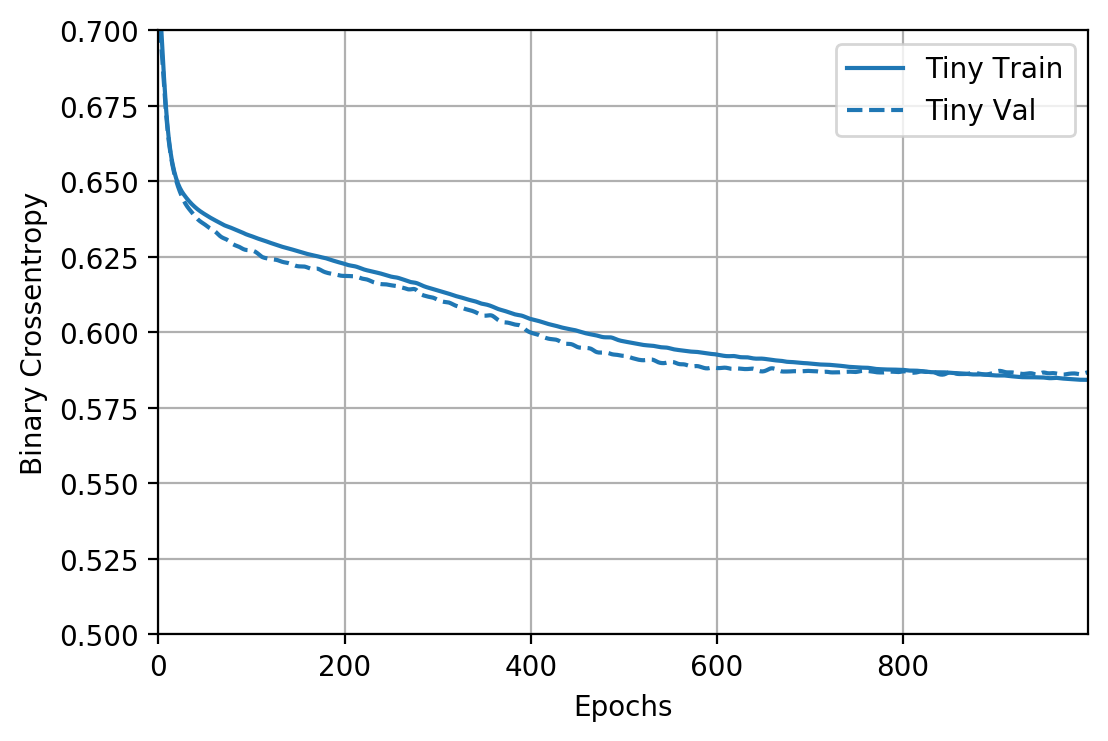

In [30]:
plotter = HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [31]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4672,  binary_crossentropy:0.7465,  loss:0.7465,  val_accuracy:0.4650,  val_binary_crossentropy:0.7183,  val_loss:0.7183,  
....................................................................................................
Epoch: 100, accuracy:0.6359,  binary_crossentropy:0.6071,  loss:0.6071,  val_accuracy:0.6310,  val_binary_crossentropy:0.6056,  val_loss:0.

In [32]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4861,  binary_crossentropy:0.6991,  loss:0.6991,  val_accuracy:0.4690,  val_binary_crossentropy:0.6753,  val_loss:0.6753,  
....................................................................................................
E

In [33]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5176,  binary_crossentropy:0.8114,  loss:0.8114,  val_accuracy:0.4780,  val_binary_crossentr

In [34]:
size_histories

{'Tiny': <tensorflow.python.keras.callbacks.History at 0x27e1af3c988>,
 'Small': <tensorflow.python.keras.callbacks.History at 0x27e1eaab1c8>,
 'Medium': <tensorflow.python.keras.callbacks.History at 0x27e1ec76ac8>,
 'large': <tensorflow.python.keras.callbacks.History at 0x27e1d2d1948>}

Text(0.5, 0, 'Epochs [Log Scale]')

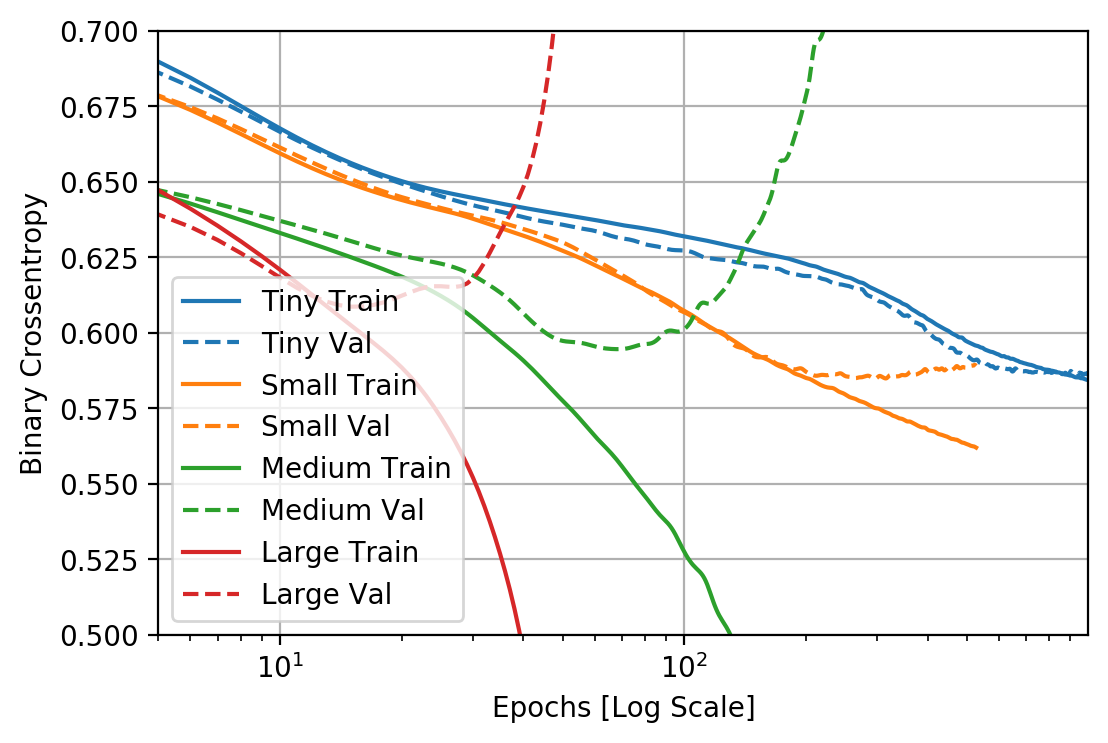

In [35]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [37]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [38]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5060,  binary_crossentropy:0.7505,  loss:2.2463,  val_accuracy:0.5380,  val_binary_crossentr

(0.5, 0.7)

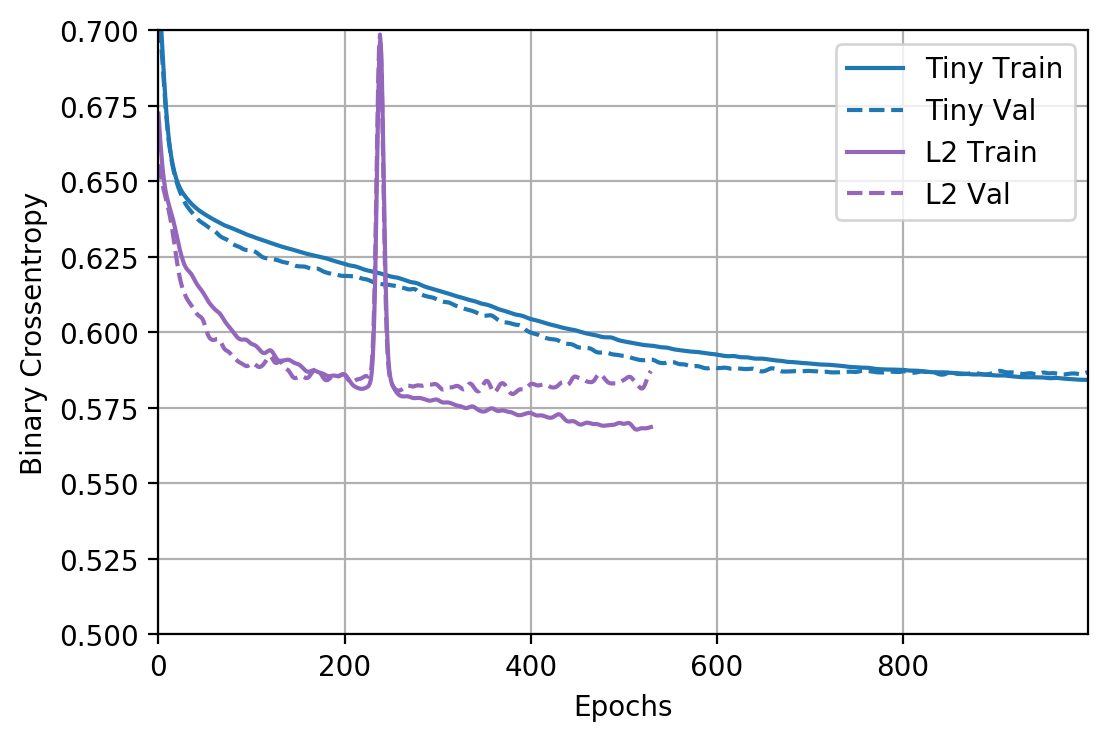

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [40]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)              

(0.5, 0.7)

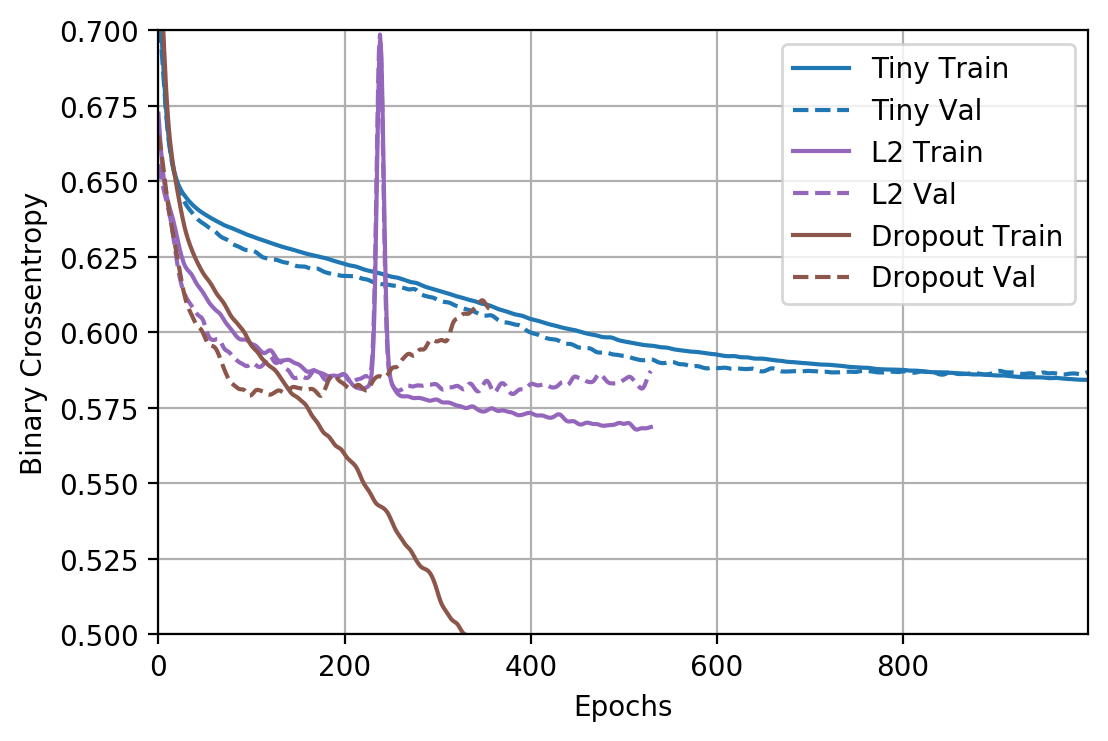

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [42]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)             

(0.5, 0.7)

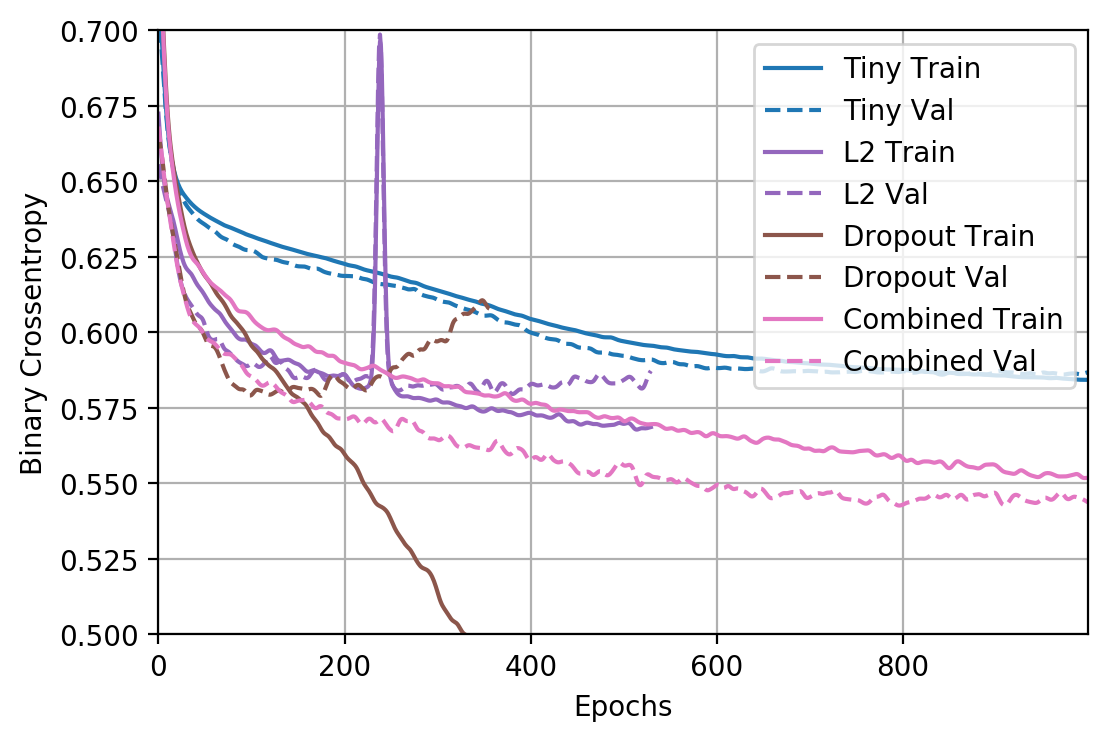

In [43]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])